In [34]:
!source .venv/bin/activate

In [35]:
from torchvision import datasets
import torch

data_folder = '/home/ramma/deep-learning/data/FMNIST' 
fmnist      = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images   = fmnist.data
tr_targets  = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

print('jumlah_data_image: ', len(tr_images), 'jumlah_data_targets: ', len(tr_targets))
device = "cuda" if torch.cuda.is_available() else "cpu"

jumlah_data_image:  60000 jumlah_data_targets:  60000


In [36]:
from torch.utils.data import Dataset
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255       # converted the input into the floating-point number 
        x = x.view(-1,28*28)    # flattened each image into 28*28 = 748
        self.x, self.y = x, y 
    def __getitem__(self,  ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device),  y.to(device)
    def __len__(self):
        return len(self.x)
    


In [37]:
from torch.utils.data import DataLoader

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train,  batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

from torch.optim import SGD
import torch.nn as nn

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss() #  cross entropy loss : loss calculation and activation function(softmax), It performs softmax internally. case multi class in ann we  not use softmax as activation function
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer
     

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()



In [38]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()
     
    



In [39]:
import numpy as np

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
     

    print("EPOCH :", epoch, "|", "LOSSES :", train_losses[-1], "|", "ACCURACIES :", train_accuracies[-1])
    print("EPOCH :", epoch, "|", "LOSSES :", val_losses[-1], "|", "ACCURACIES :", val_accuracies[-1])

    


0


EPOCH : 0 | LOSSES : 0.8411044257799785 | ACCURACIES : 0.80005
EPOCH : 0 | LOSSES : 0.613229513168335 | ACCURACIES : 0.7869
1
EPOCH : 1 | LOSSES : 0.5381917642116547 | ACCURACIES : 0.8204166666666667
EPOCH : 1 | LOSSES : 0.5385134816169739 | ACCURACIES : 0.8084
2
EPOCH : 2 | LOSSES : 0.483846390469869 | ACCURACIES : 0.8381333333333333
EPOCH : 2 | LOSSES : 0.5006948709487915 | ACCURACIES : 0.8255
3
EPOCH : 3 | LOSSES : 0.4559557325204213 | ACCURACIES : 0.8498666666666667
EPOCH : 3 | LOSSES : 0.4707563519477844 | ACCURACIES : 0.8347
4
EPOCH : 4 | LOSSES : 0.43604769569635393 | ACCURACIES : 0.8566333333333334
EPOCH : 4 | LOSSES : 0.453705757856369 | ACCURACIES : 0.8432


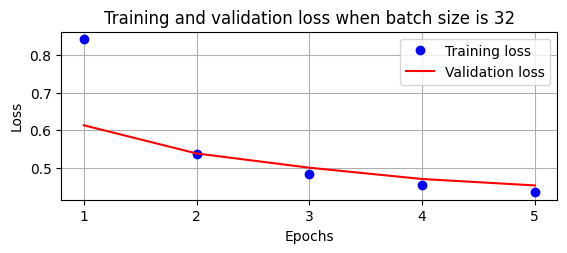

/tmp/ipykernel_39658/422203200.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


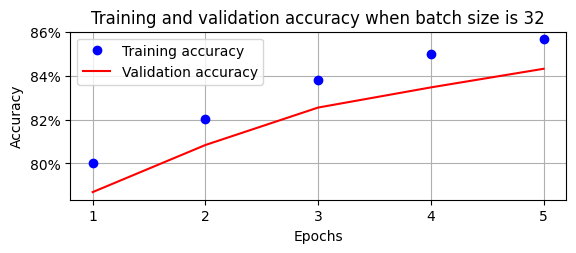

In [40]:
import matplotlib.pyplot as plt



epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()
     


In [41]:
from torch.utils.data import DataLoader

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train,  batch_size=10000, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

from torch.optim import SGD
import torch.nn as nn

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss() #  cross entropy loss : loss calculation and activation function(softmax), It performs softmax internally. case multi class in ann we  not use softmax as activation function
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer
     

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [42]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [43]:
import numpy as np

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
     

    print("EPOCH :", epoch, "|", "LOSSES :", train_losses[-1], "|", "ACCURACIES :", train_accuracies[-1])
    print("EPOCH :", epoch, "|", "LOSSES :", val_losses[-1], "|", "ACCURACIES :", val_accuracies[-1])

0
EPOCH : 0 | LOSSES : 2.296580751736959 | ACCURACIES : 0.23158333333333334
EPOCH : 0 | LOSSES : 2.263324499130249 | ACCURACIES : 0.2332
1
EPOCH : 1 | LOSSES : 2.241109768549601 | ACCURACIES : 0.3263666666666667
EPOCH : 1 | LOSSES : 2.2126691341400146 | ACCURACIES : 0.3258
2
EPOCH : 2 | LOSSES : 2.1925015846888223 | ACCURACIES : 0.44321666666666665
EPOCH : 2 | LOSSES : 2.1669809818267822 | ACCURACIES : 0.4378
3
EPOCH : 3 | LOSSES : 2.147925098737081 | ACCURACIES : 0.50725
EPOCH : 3 | LOSSES : 2.1242332458496094 | ACCURACIES : 0.5036
4
EPOCH : 4 | LOSSES : 2.105732282002767 | ACCURACIES : 0.5406333333333333
EPOCH : 4 | LOSSES : 2.083244562149048 | ACCURACIES : 0.5392


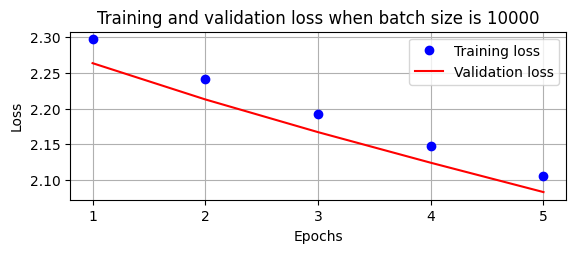

/tmp/ipykernel_39658/1383221807.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


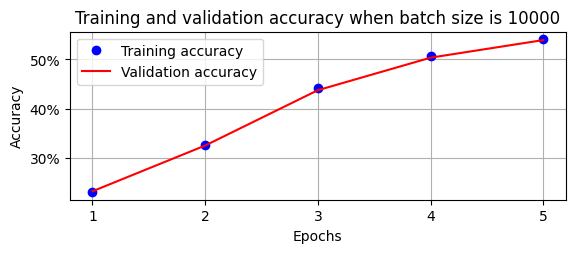

In [44]:
import matplotlib.pyplot as plt



epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()